In [4]:
import numpy as np
from sklearn.datasets import fetch_openml
import cv2
from sklearn.cluster import KMeans
import skimage.io
from matplotlib import pyplot as plt
import tempfile
import tarfile
import io
from pathlib import Path
import pickle
from skimage.color import rgb2gray
import requests

In [5]:
# Fetch dataset
if False:
    mnist = fetch_openml('mnist_784', version=1,)
    data = mnist['data'].reshape(-1, 28, 28).astype(np.uint8)

In [38]:
if True:
    response = requests.get('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    tar = tarfile.open(fileobj=io.BytesIO(response.content))
    with tempfile.TemporaryDirectory() as tempdir:
        tar.extractall(tempdir)
        p = Path(tempdir) / "cifar-10-batches-py" / "data_batch_1"
        data = (255 * rgb2gray(pickle.loads(p.read_bytes(),encoding='bytes')[b'data'].reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1]))).astype(np.uint8)

In [39]:
if True:
    data = data[:4096]

In [40]:
# Calculate SIFT features
sift = cv2.xfeatures2d_SIFT.create()
keypoints, features = zip(*[sift.detectAndCompute(d, None) for d in data])

In [41]:
# Define a function to calculate BoF
all_features = np.vstack([f for f in features if f is not None])
kmeans = KMeans(n_clusters=256, random_state=0).fit(all_features)
def calc_bof(feature):
    if feature is None:
        return np.zeros(kmeans.n_clusters).astype(np.int32)
    codes = kmeans.predict(feature)
    bof, _ = np.histogram(codes, bins=range(kmeans.n_clusters + 1))
    return bof.astype(np.int32)

In [42]:
# Clculate BoF
bof_features = [calc_bof(f) for f in features]

In [51]:
smilar_image_indice = np.argsort(np.sum(np.abs(bof_features - bof_features[1200]),axis=1))[:10]

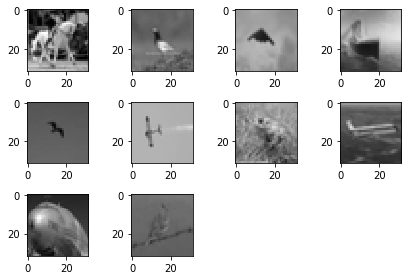

In [52]:
for i,j in enumerate(smilar_image_indice):
    plt.subplot(3,4,i + 1)
    skimage.io.imshow(data[j])
plt.show()